# Experimento 4 : Transfer learning en arquitecturas históricas.

En este experimiento usaremos la infraestructura planteada para comprobar si las arquitecturas más populares de la historia pueden mejorar la precisión de nuestra red.

## Librerías usadas.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

## Parámetros globales

In [ ]:
#Rutas de los datos.
 
data_dir = os.path.dirname(os.path.realpath("../TFG/Datos/HAM10000_metadata.csv"))



csv_path = os.path.realpath(data_dir + "/HAM10000_metadata.csv")

#Variables globales

altura = 64
longitud = 64
clases = 7


print(data_dir)

print(csv_path)



/home/antoniojesus/Escritorio/TFG/Datos
/home/antoniojesus/Escritorio/TFG/Datos/HAM10000_metadata.csv


## Creación del marco de datos.

In [ ]:
#Inicializando el dataFrame

dataFrame=pd.read_csv(csv_path)

#Mezclando carpetas.

all_image_path = glob(os.path.join(data_dir, '*', '*'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

# Inicializando diccionario de categorías

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

#Añadiendo columnas al dataFrame para que sea más legible.

dataFrame['path'] = dataFrame['image_id'].map(imageid_path_dict.get)
dataFrame['cell_type'] = dataFrame['dx'].map(lesion_type_dict.get) 
dataFrame['cell_type_idx'] = pd.Categorical(dataFrame['cell_type']).codes
dataFrame.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2


## Creación de la aruitectura

Este método permite seleccionar la parte superior de una red.

In [ ]:
def select_network(nn_base_arch):

    #Familia VGG
    if nn_base_arch == 'VGG16':
        nn = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(altura, longitud,3))   
    if nn_base_arch == 'VGG19':  
        nn = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(altura, longitud,3))
    
    
    #Familia MobileNet
    if nn_base_arch == 'MNv1':
        nn = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(altura, longitud,3))
    if nn_base_arch == 'MNv2':
        nn = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(altura, longitud,3))
        
        
    #Entradas mayor de 75 x 75    
    if nn_base_arch == 'IV3':
        nn = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(altura, longitud,3))
        
    #Entradas  mayor de 72 x 72
    if nn_base_arch == 'Xception':
        nn = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(altura, longitud,3))
          
    if nn_base_arch == 'ENB4':
        nn = tf.keras.applications.EfficientNetB4(weights='imagenet', include_top=False, input_shape=(altura, longitud,3))
    
    if nn_base_arch == 'ResNet50':  
        nn = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(altura, longitud,3))
    
    
    if nn_base_arch == 'ResNet152v2':  
        nn = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(altura, longitud,3))
    
    return nn

In [ ]:
def build(nn):
    model = tf.keras.Sequential()
    model.add(nn)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.PReLU())
    model.add(tf.keras.layers.Dropout(0.4))
    
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.PReLU())
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(clases,activation='softmax'))
  
  

    print(model.summary())

    return model

In [ ]:
#createPretrainedModel - Congela las capas de la red y le añade una capa TOP entrenable

def createPretrainedModel(nn_base_arch,layers_not_trainables = -1):
    pre_trained_model = select_network(nn_base_arch)
    
    for layer in pre_trained_model.layers[0:layers_not_trainables]:
        layer.trainable = False
        
    nn = build(pre_trained_model)
    nn.summary()
    
    return nn
    

## Carga de imágenes

In [ ]:
def balanced_dataset(df):
    df_balanced = pd.DataFrame()
    #df = pd.DataFrame()
    
    for cat in df['cell_type_idx'].unique():
        temp = resample(df[df['cell_type_idx'] == cat], 
                        replace=True,     # sample with replacement
                        n_samples=2500,   # to match majority class
                        random_state=123) # reproducible results

        # Combine majority class with upsampled minority class
        df_balanced = pd.concat([df_balanced, temp])
 
    df_balanced['cell_type'].value_counts()

    return df_balanced

def load_img_data(size, df, balanced=False):
    """
        ..
        first we should normalize the image from 0-255 to 0-1
    """
    
    img_h, img_w = size, size
    imgs = []
    
    if balanced:
        df = balanced_dataset(df)
    
    image_paths = list(df['path'])

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        #img = np.asarray(Image.open(image_paths[i]).resize((size,size)))
        imgs.append(img)

    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)

    #imgs = imgs.astype(np.float32) / 255.
    
    return imgs, df['cell_type_idx'].values

In [ ]:
del dataFrame
del imgs
del target
del x_train
del x_test
del y_train
del y_test
del x_val
del y_val

In [ ]:
imgs, target = load_img_data(altura, dataFrame, balanced=True)

100%|██████████| 17500/17500 [03:39<00:00, 79.67it/s] 


(17500, 64, 64, 3)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(imgs, target, test_size=0.20)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05)

train_val_test = (x_train, y_train, x_val, y_val, x_test, y_test)

[x_train.shape, x_val.shape, x_test.shape]

trainX = train_val_test[0]
trainY = train_val_test[1]
valX = train_val_test[2]
valY = train_val_test[3]
testX = train_val_test[4]
testY = train_val_test[5]

numTrainingSamples = trainX.shape[0]
numValidationSamples = valX.shape[0]

### Generamos algunos paramentros adicionale para el entrenamiento

In [ ]:
mini_batch_size =numTrainingSamples/875
mbs=int(mini_batch_size)
mbs


15

In [ ]:
optAMSGrad = tf.keras.optimizers.Adam(
    learning_rate=0.0005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="AMSGrad"

)


## Definimos run_train y re_train.

El primero construirá la red y la entrenará, el segundo nos permitirá volver a entrenar un modelo previamente entrenado.

In [ ]:
def run_train(nn_base_arch,checkpoint,epocas):
    
    model = createPretrainedModel(nn_base_arch,20)
        
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint,
                                                    monitor="val_loss",
                                                    mode="min",
                                                    save_best_only=True,
                                                    verbose=1)
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optAMSGrad,
                  metrics=['accuracy','mse'])
    
    
    history = model.fit(x_train, y_train,
                        steps_per_epoch=(numTrainingSamples/(mbs*25)),
                        epochs=epocas,
                        validation_data=(valX, valY),
                        callbacks=[checkpoint],
                        batch_size = mbs)
  
    return history

def re_train(model,checkpoint,epocas):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
    history = model.fit(x_train, y_train,steps_per_epoch=(numTrainingSamples/(mbs*25)),epochs=epocas,validation_data=(valX, valY),callbacks=[checkpoint],batch_size = mbs)
  
    return history

In [ ]:
epocas = 500
nn_base_arch = "ResNet152v2"
checkpoint ="../TFG/Modelos/balanced_model_"+nn_base_arch+"_EXP_3_ph1_weights.h5"
history = run_train(nn_base_arch,checkpoint,epocas)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 2, 2, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
p_re_lu_8 (PReLU)            (None, 1024)              1024      
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)             

Epoch 15/500
36/35 [==============================] - ETA: 0s - loss: 1.1585 - accuracy: 0.5667 - mse: 11.7129
Epoch 00015: val_loss did not improve from 1.53232
36/35 [==============================] - 49s 1s/step - loss: 1.1585 - accuracy: 0.5667 - mse: 11.7129 - val_loss: 2.6287 - val_accuracy: 0.4843 - val_mse: 12.3398
Epoch 16/500
36/35 [==============================] - ETA: 0s - loss: 1.2384 - accuracy: 0.5500 - mse: 13.2864
Epoch 00016: val_loss improved from 1.53232 to 1.14909, saving model to ../TFG/Modelos/balanced_model_ResNet152v2_EXP_3_ph1_weights.h5
36/35 [==============================] - 59s 2s/step - loss: 1.2384 - accuracy: 0.5500 - mse: 13.2864 - val_loss: 1.1491 - val_accuracy: 0.5871 - val_mse: 12.3223
Epoch 17/500
36/35 [==============================] - ETA: 0s - loss: 1.1048 - accuracy: 0.6056 - mse: 13.1215
Epoch 00017: val_loss did not improve from 1.14909
36/35 [==============================] - 48s 1s/step - loss: 1.1048 - accuracy: 0.6056 - mse: 13.1215 - 

Epoch 40/500
36/35 [==============================] - ETA: 0s - loss: 1.2387 - accuracy: 0.5407 - mse: 11.2754
Epoch 00040: val_loss did not improve from 1.14909
36/35 [==============================] - 54s 1s/step - loss: 1.2387 - accuracy: 0.5407 - mse: 11.2754 - val_loss: 1462.0020 - val_accuracy: 0.1500 - val_mse: 12.3980
Epoch 41/500
36/35 [==============================] - ETA: 0s - loss: 1.4597 - accuracy: 0.4481 - mse: 13.0474
Epoch 00041: val_loss did not improve from 1.14909
36/35 [==============================] - 55s 2s/step - loss: 1.4597 - accuracy: 0.4481 - mse: 13.0474 - val_loss: 1152.6783 - val_accuracy: 0.1714 - val_mse: 12.3931
Epoch 42/500
36/35 [==============================] - ETA: 0s - loss: 1.3386 - accuracy: 0.4981 - mse: 11.0229
Epoch 00042: val_loss did not improve from 1.14909
36/35 [==============================] - 55s 2s/step - loss: 1.3386 - accuracy: 0.4981 - mse: 11.0229 - val_loss: 2.6679 - val_accuracy: 0.4243 - val_mse: 12.3347
Epoch 43/500
36/35 

Epoch 65/500
36/35 [==============================] - ETA: 0s - loss: 0.8908 - accuracy: 0.6648 - mse: 11.7757
Epoch 00065: val_loss did not improve from 0.89839
36/35 [==============================] - 55s 2s/step - loss: 0.8908 - accuracy: 0.6648 - mse: 11.7757 - val_loss: 2.0128 - val_accuracy: 0.6843 - val_mse: 12.3456
Epoch 66/500
36/35 [==============================] - ETA: 0s - loss: 0.7966 - accuracy: 0.7074 - mse: 12.2046
Epoch 00066: val_loss did not improve from 0.89839
36/35 [==============================] - 55s 2s/step - loss: 0.7966 - accuracy: 0.7074 - mse: 12.2046 - val_loss: 1.1664 - val_accuracy: 0.7429 - val_mse: 12.3513
Epoch 67/500
36/35 [==============================] - ETA: 0s - loss: 0.8505 - accuracy: 0.6741 - mse: 12.5795
Epoch 00067: val_loss improved from 0.89839 to 0.84727, saving model to ../TFG/Modelos/balanced_model_ResNet152v2_EXP_3_ph1_weights.h5
36/35 [==============================] - 75s 2s/step - loss: 0.8505 - accuracy: 0.6741 - mse: 12.5795 - 

Epoch 90/500
36/35 [==============================] - ETA: 0s - loss: 0.6228 - accuracy: 0.7778 - mse: 11.7352
Epoch 00090: val_loss did not improve from 0.62844
36/35 [==============================] - 54s 2s/step - loss: 0.6228 - accuracy: 0.7778 - mse: 11.7352 - val_loss: 2.6891 - val_accuracy: 0.8086 - val_mse: 12.3660
Epoch 91/500
36/35 [==============================] - ETA: 0s - loss: 0.5421 - accuracy: 0.8111 - mse: 13.0619
Epoch 00091: val_loss did not improve from 0.62844
36/35 [==============================] - 54s 2s/step - loss: 0.5421 - accuracy: 0.8111 - mse: 13.0619 - val_loss: 3.2360 - val_accuracy: 0.8143 - val_mse: 12.3691
Epoch 92/500
36/35 [==============================] - ETA: 0s - loss: 0.5831 - accuracy: 0.8000 - mse: 11.6882
Epoch 00092: val_loss did not improve from 0.62844
36/35 [==============================] - 56s 2s/step - loss: 0.5831 - accuracy: 0.8000 - mse: 11.6882 - val_loss: 274.1169 - val_accuracy: 0.3629 - val_mse: 12.3786
Epoch 93/500
36/35 [===

36/35 [==============================] - ETA: 0s - loss: 0.6458 - accuracy: 0.7593 - mse: 12.6355
Epoch 00114: val_loss did not improve from 0.53957
36/35 [==============================] - 54s 2s/step - loss: 0.6458 - accuracy: 0.7593 - mse: 12.6355 - val_loss: 6.5876 - val_accuracy: 0.7386 - val_mse: 12.3494
Epoch 115/500
36/35 [==============================] - ETA: 0s - loss: 0.6570 - accuracy: 0.7630 - mse: 13.3174
Epoch 00115: val_loss did not improve from 0.53957
36/35 [==============================] - 55s 2s/step - loss: 0.6570 - accuracy: 0.7630 - mse: 13.3174 - val_loss: 1355.2869 - val_accuracy: 0.4643 - val_mse: 12.3759
Epoch 116/500
36/35 [==============================] - ETA: 0s - loss: 0.6564 - accuracy: 0.7556 - mse: 11.1192
Epoch 00116: val_loss did not improve from 0.53957
36/35 [==============================] - 54s 1s/step - loss: 0.6564 - accuracy: 0.7556 - mse: 11.1192 - val_loss: 214.4798 - val_accuracy: 0.6457 - val_mse: 12.3579
Epoch 117/500
36/35 [==========

Epoch 139/500
36/35 [==============================] - ETA: 0s - loss: 0.5032 - accuracy: 0.8074 - mse: 11.7280
Epoch 00139: val_loss did not improve from 0.46817
36/35 [==============================] - 43s 1s/step - loss: 0.5032 - accuracy: 0.8074 - mse: 11.7280 - val_loss: 97.6044 - val_accuracy: 0.8171 - val_mse: 12.3702
Epoch 140/500
36/35 [==============================] - ETA: 0s - loss: 0.5928 - accuracy: 0.7870 - mse: 12.1601
Epoch 00140: val_loss did not improve from 0.46817
36/35 [==============================] - 43s 1s/step - loss: 0.5928 - accuracy: 0.7870 - mse: 12.1601 - val_loss: 95.6669 - val_accuracy: 0.7371 - val_mse: 12.3458
Epoch 141/500
36/35 [==============================] - ETA: 0s - loss: 0.5441 - accuracy: 0.7926 - mse: 13.2823
Epoch 00141: val_loss did not improve from 0.46817
36/35 [==============================] - 43s 1s/step - loss: 0.5441 - accuracy: 0.7926 - mse: 13.2823 - val_loss: 4522.9873 - val_accuracy: 0.7457 - val_mse: 12.3722
Epoch 142/500
36/

Epoch 164/500
36/35 [==============================] - ETA: 0s - loss: 0.3936 - accuracy: 0.8519 - mse: 11.5666
Epoch 00164: val_loss did not improve from 0.43023
36/35 [==============================] - 43s 1s/step - loss: 0.3936 - accuracy: 0.8519 - mse: 11.5666 - val_loss: 25.2877 - val_accuracy: 0.8814 - val_mse: 12.3799
Epoch 165/500
36/35 [==============================] - ETA: 0s - loss: 0.3766 - accuracy: 0.8685 - mse: 12.8876
Epoch 00165: val_loss did not improve from 0.43023
36/35 [==============================] - 43s 1s/step - loss: 0.3766 - accuracy: 0.8685 - mse: 12.8876 - val_loss: 10.1488 - val_accuracy: 0.8857 - val_mse: 12.3836
Epoch 166/500
36/35 [==============================] - ETA: 0s - loss: 0.4089 - accuracy: 0.8444 - mse: 12.9307
Epoch 00166: val_loss did not improve from 0.43023
36/35 [==============================] - 42s 1s/step - loss: 0.4089 - accuracy: 0.8444 - mse: 12.9307 - val_loss: 5.3775 - val_accuracy: 0.8700 - val_mse: 12.3814
Epoch 167/500
36/35 

36/35 [==============================] - ETA: 0s - loss: 0.3032 - accuracy: 0.8926 - mse: 12.3836
Epoch 00189: val_loss did not improve from 0.43023
36/35 [==============================] - 43s 1s/step - loss: 0.3032 - accuracy: 0.8926 - mse: 12.3836 - val_loss: 29.8640 - val_accuracy: 0.8829 - val_mse: 12.3867
Epoch 190/500
36/35 [==============================] - ETA: 0s - loss: 0.3063 - accuracy: 0.8796 - mse: 12.9469
Epoch 00190: val_loss did not improve from 0.43023
36/35 [==============================] - 42s 1s/step - loss: 0.3063 - accuracy: 0.8796 - mse: 12.9469 - val_loss: 21.8825 - val_accuracy: 0.8929 - val_mse: 12.3883
Epoch 191/500
36/35 [==============================] - ETA: 0s - loss: 0.3016 - accuracy: 0.8889 - mse: 12.0341
Epoch 00191: val_loss did not improve from 0.43023
36/35 [==============================] - 43s 1s/step - loss: 0.3016 - accuracy: 0.8889 - mse: 12.0341 - val_loss: 24.8899 - val_accuracy: 0.8786 - val_mse: 12.3890
Epoch 192/500
36/35 [============

36/35 [==============================] - ETA: 0s - loss: 1.0916 - accuracy: 0.6352 - mse: 12.0172
Epoch 00214: val_loss did not improve from 0.43023
36/35 [==============================] - 43s 1s/step - loss: 1.0916 - accuracy: 0.6352 - mse: 12.0172 - val_loss: 1.4467 - val_accuracy: 0.4371 - val_mse: 12.3053
Epoch 215/500
36/35 [==============================] - ETA: 0s - loss: 1.1196 - accuracy: 0.5963 - mse: 11.9968
Epoch 00215: val_loss did not improve from 0.43023
36/35 [==============================] - 43s 1s/step - loss: 1.1196 - accuracy: 0.5963 - mse: 11.9968 - val_loss: 14.5125 - val_accuracy: 0.5900 - val_mse: 12.3232
Epoch 216/500
36/35 [==============================] - ETA: 0s - loss: 1.1575 - accuracy: 0.5704 - mse: 13.0764
Epoch 00216: val_loss did not improve from 0.43023
36/35 [==============================] - 43s 1s/step - loss: 1.1575 - accuracy: 0.5704 - mse: 13.0764 - val_loss: 76900.2578 - val_accuracy: 0.3786 - val_mse: 12.3367
Epoch 217/500
36/35 [==========

36/35 [==============================] - ETA: 0s - loss: 0.4380 - accuracy: 0.8500 - mse: 12.2328
Epoch 00239: val_loss did not improve from 0.43023
36/35 [==============================] - 42s 1s/step - loss: 0.4380 - accuracy: 0.8500 - mse: 12.2328 - val_loss: 3.6612 - val_accuracy: 0.8257 - val_mse: 12.3747
Epoch 240/500
36/35 [==============================] - ETA: 0s - loss: 0.4415 - accuracy: 0.8407 - mse: 12.3183
Epoch 00240: val_loss did not improve from 0.43023
36/35 [==============================] - 43s 1s/step - loss: 0.4415 - accuracy: 0.8407 - mse: 12.3183 - val_loss: 0.7586 - val_accuracy: 0.8586 - val_mse: 12.3739
Epoch 241/500
36/35 [==============================] - ETA: 0s - loss: 0.4835 - accuracy: 0.8130 - mse: 12.6800
Epoch 00241: val_loss did not improve from 0.43023
36/35 [==============================] - 43s 1s/step - loss: 0.4835 - accuracy: 0.8130 - mse: 12.6800 - val_loss: 1.4905 - val_accuracy: 0.8429 - val_mse: 12.3756
Epoch 242/500
36/35 [===============

Epoch 264/500
36/35 [==============================] - ETA: 0s - loss: 0.4731 - accuracy: 0.8407 - mse: 12.1309
Epoch 00264: val_loss did not improve from 0.32170
36/35 [==============================] - 43s 1s/step - loss: 0.4731 - accuracy: 0.8407 - mse: 12.1309 - val_loss: 0.3418 - val_accuracy: 0.8814 - val_mse: 12.3791
Epoch 265/500
36/35 [==============================] - ETA: 0s - loss: 0.4356 - accuracy: 0.8407 - mse: 11.9359
Epoch 00265: val_loss improved from 0.32170 to 0.29719, saving model to ../TFG/Modelos/balanced_model_ResNet152v2_EXP_3_ph1_weights.h5
36/35 [==============================] - 60s 2s/step - loss: 0.4356 - accuracy: 0.8407 - mse: 11.9359 - val_loss: 0.2972 - val_accuracy: 0.8986 - val_mse: 12.3838
Epoch 266/500
36/35 [==============================] - ETA: 0s - loss: 0.4623 - accuracy: 0.8481 - mse: 11.8457
Epoch 00266: val_loss improved from 0.29719 to 0.27479, saving model to ../TFG/Modelos/balanced_model_ResNet152v2_EXP_3_ph1_weights.h5
36/35 [==========

Epoch 289/500
36/35 [==============================] - ETA: 0s - loss: 0.3514 - accuracy: 0.8852 - mse: 12.3901
Epoch 00289: val_loss did not improve from 0.27479
36/35 [==============================] - 43s 1s/step - loss: 0.3514 - accuracy: 0.8852 - mse: 12.3901 - val_loss: 1.3928 - val_accuracy: 0.8971 - val_mse: 12.3861
Epoch 290/500
36/35 [==============================] - ETA: 0s - loss: 0.3786 - accuracy: 0.8778 - mse: 12.8660
Epoch 00290: val_loss did not improve from 0.27479
36/35 [==============================] - 42s 1s/step - loss: 0.3786 - accuracy: 0.8778 - mse: 12.8660 - val_loss: 140.7602 - val_accuracy: 0.6557 - val_mse: 12.3673
Epoch 291/500
36/35 [==============================] - ETA: 0s - loss: 0.8510 - accuracy: 0.6963 - mse: 11.6918
Epoch 00291: val_loss did not improve from 0.27479
36/35 [==============================] - 44s 1s/step - loss: 0.8510 - accuracy: 0.6963 - mse: 11.6918 - val_loss: 15.1962 - val_accuracy: 0.6429 - val_mse: 12.3492
Epoch 292/500
36/35

36/35 [==============================] - ETA: 0s - loss: 0.9999 - accuracy: 0.6315 - mse: 12.4245
Epoch 00314: val_loss did not improve from 0.27479
36/35 [==============================] - 43s 1s/step - loss: 0.9999 - accuracy: 0.6315 - mse: 12.4245 - val_loss: 297.7785 - val_accuracy: 0.5057 - val_mse: 12.3600
Epoch 315/500
36/35 [==============================] - ETA: 0s - loss: 0.9187 - accuracy: 0.6556 - mse: 12.2336
Epoch 00315: val_loss did not improve from 0.27479
36/35 [==============================] - 42s 1s/step - loss: 0.9187 - accuracy: 0.6556 - mse: 12.2336 - val_loss: 113.3394 - val_accuracy: 0.5157 - val_mse: 12.3587
Epoch 316/500
36/35 [==============================] - ETA: 0s - loss: 0.8634 - accuracy: 0.6870 - mse: 12.1621
Epoch 00316: val_loss did not improve from 0.27479
36/35 [==============================] - 42s 1s/step - loss: 0.8634 - accuracy: 0.6870 - mse: 12.1621 - val_loss: 14.9599 - val_accuracy: 0.6414 - val_mse: 12.3531
Epoch 317/500
36/35 [==========

36/35 [==============================] - ETA: 0s - loss: 0.4492 - accuracy: 0.8204 - mse: 13.2672
Epoch 00339: val_loss did not improve from 0.27479
36/35 [==============================] - 43s 1s/step - loss: 0.4492 - accuracy: 0.8204 - mse: 13.2672 - val_loss: 0.3641 - val_accuracy: 0.8757 - val_mse: 12.3804
Epoch 340/500
36/35 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 0.8759 - mse: 12.0510
Epoch 00340: val_loss did not improve from 0.27479
36/35 [==============================] - 43s 1s/step - loss: 0.3480 - accuracy: 0.8759 - mse: 12.0510 - val_loss: 0.3811 - val_accuracy: 0.8729 - val_mse: 12.3822
Epoch 341/500
36/35 [==============================] - ETA: 0s - loss: 0.3509 - accuracy: 0.8593 - mse: 11.5554
Epoch 00341: val_loss did not improve from 0.27479
36/35 [==============================] - 43s 1s/step - loss: 0.3509 - accuracy: 0.8593 - mse: 11.5554 - val_loss: 8.3494 - val_accuracy: 0.8871 - val_mse: 12.3850
Epoch 342/500
36/35 [===============

36/35 [==============================] - ETA: 0s - loss: 0.3512 - accuracy: 0.8648 - mse: 12.2725
Epoch 00364: val_loss did not improve from 0.27479
36/35 [==============================] - 62s 2s/step - loss: 0.3512 - accuracy: 0.8648 - mse: 12.2725 - val_loss: 16.0615 - val_accuracy: 0.8700 - val_mse: 12.3862
Epoch 365/500
36/35 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.8852 - mse: 12.2266
Epoch 00365: val_loss did not improve from 0.27479
36/35 [==============================] - 63s 2s/step - loss: 0.3292 - accuracy: 0.8852 - mse: 12.2266 - val_loss: 19.3663 - val_accuracy: 0.8800 - val_mse: 12.3872
Epoch 366/500
36/35 [==============================] - ETA: 0s - loss: 0.3044 - accuracy: 0.8944 - mse: 12.7737
Epoch 00366: val_loss did not improve from 0.27479
36/35 [==============================] - 62s 2s/step - loss: 0.3044 - accuracy: 0.8944 - mse: 12.7737 - val_loss: 11.0991 - val_accuracy: 0.8843 - val_mse: 12.3896
Epoch 367/500
36/35 [============

36/35 [==============================] - ETA: 0s - loss: 0.2492 - accuracy: 0.9204 - mse: 11.5343
Epoch 00389: val_loss did not improve from 0.27479
36/35 [==============================] - 71s 2s/step - loss: 0.2492 - accuracy: 0.9204 - mse: 11.5343 - val_loss: 5.4168 - val_accuracy: 0.9071 - val_mse: 12.3925
Epoch 390/500
36/35 [==============================] - ETA: 0s - loss: 0.2407 - accuracy: 0.9130 - mse: 11.9991
Epoch 00390: val_loss did not improve from 0.27479
36/35 [==============================] - 71s 2s/step - loss: 0.2407 - accuracy: 0.9130 - mse: 11.9991 - val_loss: 6.3221 - val_accuracy: 0.8857 - val_mse: 12.3923
Epoch 391/500
36/35 [==============================] - ETA: 0s - loss: 0.2552 - accuracy: 0.9148 - mse: 12.9392
Epoch 00391: val_loss did not improve from 0.27479
36/35 [==============================] - 71s 2s/step - loss: 0.2552 - accuracy: 0.9148 - mse: 12.9392 - val_loss: 0.5783 - val_accuracy: 0.8429 - val_mse: 12.3876
Epoch 392/500
36/35 [===============

36/35 [==============================] - ETA: 0s - loss: 0.8034 - accuracy: 0.6907 - mse: 12.4771
Epoch 00414: val_loss did not improve from 0.27479
36/35 [==============================] - 71s 2s/step - loss: 0.8034 - accuracy: 0.6907 - mse: 12.4771 - val_loss: 24.7776 - val_accuracy: 0.6814 - val_mse: 12.3507
Epoch 415/500
36/35 [==============================] - ETA: 0s - loss: 0.7373 - accuracy: 0.7278 - mse: 12.8304
Epoch 00415: val_loss did not improve from 0.27479
36/35 [==============================] - 76s 2s/step - loss: 0.7373 - accuracy: 0.7278 - mse: 12.8304 - val_loss: 6.4949 - val_accuracy: 0.6800 - val_mse: 12.3514
Epoch 416/500
36/35 [==============================] - ETA: 0s - loss: 0.7378 - accuracy: 0.7019 - mse: 12.6582
Epoch 00416: val_loss did not improve from 0.27479
36/35 [==============================] - 79s 2s/step - loss: 0.7378 - accuracy: 0.7019 - mse: 12.6582 - val_loss: 1.2348 - val_accuracy: 0.7271 - val_mse: 12.3517
Epoch 417/500
36/35 [==============

36/35 [==============================] - ETA: 0s - loss: 0.4474 - accuracy: 0.8352 - mse: 13.1862
Epoch 00439: val_loss did not improve from 0.27479
36/35 [==============================] - 54s 2s/step - loss: 0.4474 - accuracy: 0.8352 - mse: 13.1862 - val_loss: 1.7727 - val_accuracy: 0.8571 - val_mse: 12.3758
Epoch 440/500
36/35 [==============================] - ETA: 0s - loss: 0.4162 - accuracy: 0.8574 - mse: 11.6472
Epoch 00440: val_loss did not improve from 0.27479
36/35 [==============================] - 58s 2s/step - loss: 0.4162 - accuracy: 0.8574 - mse: 11.6472 - val_loss: 0.9897 - val_accuracy: 0.8500 - val_mse: 12.3812
Epoch 441/500
36/35 [==============================] - ETA: 0s - loss: 0.4166 - accuracy: 0.8407 - mse: 11.8034
Epoch 00441: val_loss did not improve from 0.27479
36/35 [==============================] - 69s 2s/step - loss: 0.4166 - accuracy: 0.8407 - mse: 11.8034 - val_loss: 3.2503 - val_accuracy: 0.8571 - val_mse: 12.3732
Epoch 442/500
36/35 [===============

36/35 [==============================] - ETA: 0s - loss: 0.3598 - accuracy: 0.8574 - mse: 12.0937
Epoch 00464: val_loss did not improve from 0.27479
36/35 [==============================] - 61s 2s/step - loss: 0.3598 - accuracy: 0.8574 - mse: 12.0937 - val_loss: 32.2638 - val_accuracy: 0.8829 - val_mse: 12.3863
Epoch 465/500
36/35 [==============================] - ETA: 0s - loss: 0.3698 - accuracy: 0.8630 - mse: 12.1099
Epoch 00465: val_loss did not improve from 0.27479
36/35 [==============================] - 61s 2s/step - loss: 0.3698 - accuracy: 0.8630 - mse: 12.1099 - val_loss: 27.8432 - val_accuracy: 0.8829 - val_mse: 12.3843
Epoch 466/500
36/35 [==============================] - ETA: 0s - loss: 0.3567 - accuracy: 0.8574 - mse: 13.1791
Epoch 00466: val_loss did not improve from 0.27479
36/35 [==============================] - 61s 2s/step - loss: 0.3567 - accuracy: 0.8574 - mse: 13.1791 - val_loss: 31.2083 - val_accuracy: 0.8814 - val_mse: 12.3863
Epoch 467/500
36/35 [============

36/35 [==============================] - ETA: 0s - loss: 0.3233 - accuracy: 0.8722 - mse: 11.6070
Epoch 00489: val_loss did not improve from 0.27479
36/35 [==============================] - 44s 1s/step - loss: 0.3233 - accuracy: 0.8722 - mse: 11.6070 - val_loss: 36.8932 - val_accuracy: 0.9029 - val_mse: 12.3885
Epoch 490/500
36/35 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.8963 - mse: 12.1653
Epoch 00490: val_loss did not improve from 0.27479
36/35 [==============================] - 46s 1s/step - loss: 0.2754 - accuracy: 0.8963 - mse: 12.1653 - val_loss: 38.6958 - val_accuracy: 0.8957 - val_mse: 12.3911
Epoch 491/500
36/35 [==============================] - ETA: 0s - loss: 0.2550 - accuracy: 0.8963 - mse: 12.2520
Epoch 00491: val_loss did not improve from 0.27479
36/35 [==============================] - 44s 1s/step - loss: 0.2550 - accuracy: 0.8963 - mse: 12.2520 - val_loss: 61.1116 - val_accuracy: 0.9029 - val_mse: 12.3930
Epoch 492/500
36/35 [============

In [ ]:
nn_base_arch = "MNv1"
checkpoint ="../TFG/Modelos/balanced_model_"+nn_base_arch+"_EXP_3_ph2_weights.h5"

history.model.save(checkpoint)

In [ ]:
tf_model = tf.keras.models.load_model(checkpoint)

tf_model.compile(loss='sparse_categorical_crossentropy', optimizer=optAMSGrad, metrics=['accuracy'])

In [ ]:
def plot_loss(history,epochs,name):
  print('\n\n')     
  plt.figure(figsize=(12,8))
  plt.plot(np.arange(400, epochs), history.history["loss"][400:epochs], label="train_loss")
  plt.plot(np.arange(400, epochs), history.history["val_loss"][400:epochs], label="val_loss")
  plt.plot(np.arange(400, epochs), history.history["accuracy"][400:epochs], label="train_acc")
  plt.plot(np.arange(400, epochs), history.history["val_accuracy"][400:epochs], label="val_acc")
  plt.title("Training Loss and Accuracy - {}".format(name))
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()

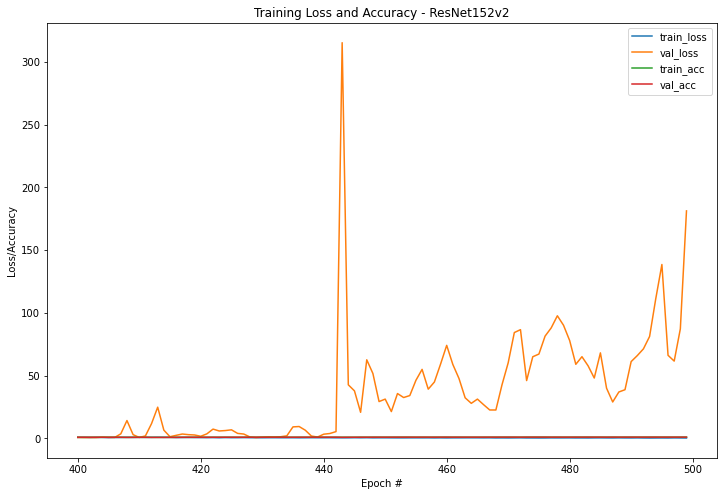

In [ ]:
plot_loss(history,epocas,nn_base_arch)

## Evalución con el subconjunto de test.

In [ ]:
test_eval = tf_model.evaluate(x_test, y_test)

110/110 [==============================] - 31s 286ms/step - loss: 0.5288 - accuracy: 0.8889


In [ ]:
test_eval = history.model.evaluate(x_test, y_test)

110/110 [==============================] - 32s 294ms/step - loss: 174.8500 - accuracy: 0.9026 - mse: 12.3187
